## Model 3

### Sprint 4 CAPSTONE PROJECT

#               <h1><center>Home Credit Group</center></h1>
## <h2><center>Loan Behavior Predictor</center></h2>    


# Table of Content
I.	Introduction.

II.	Data loading.

III. Aggregation strategies for the tables.

IV.	Exploratory data analysis.

V.	Statistical Inference.

VI.	Modeling.

VII.	Conclusions.

VIII.	Recommendations.

# I. Introduction

#### I.1. The Goals of the Project

The goal of this project is to create a web service to predict credit aplicants behavior. The data for this project contains various tables with historical applicant information. The main table is app_train, where current applicants data is provided. In addition to that there are tables from external sources that contain information about the aplicant past behavior handling previous loans, credit card and cash behavior. 

The Plan for handing data will be the following:

1. Analize all the columns of provided data.
2. Determine the aggregation feature engineering strategies for each table with the purpose to join the external sources data with the app_train table.
3. Perform EDA with the purpose to identify the key features that has an impact on the potential defaulted behavior.
4. Create the list of Major features to use for modeling.
5. Perform various model training with the Major features, full joined features, and also with the app_train original columns.
6. Identify best performing model and perform hyperparameter tunning.
7. Test the model with the app_train sample and app_test sample.
8. Load the functioning model to the cloud.

In addition, this project aims to:
1.	To analyze what were the potential criteria for rejecting the loan in the past.
2.  Practice identifying opportunities for data analysis, raising hypothesis, and formulating research tasks.
2.	Practice performing EDA, statistical inference, and prediction.
3.	Practice visualizing data.
4.  Practice machine learning modeling techniques.
5.  Practicing deploying the model for production in Google Cloud Service.

#### I.2. About Home Credit

Home Credit:

Type: Financial Services Company

Global Reach: Home Credit operates in numerous countries, primarily in Asia and Eastern Europe.

Services: They offer a range of financial products, including consumer loans, point-of-sale financing, and credit cards.
Target Audience: Home Credit often serves customers with limited credit histories or low income, helping them access credit for purchasing goods and services.

Innovation: The company is known for its innovative approach to credit assessment, using non-traditional data sources to evaluate applicants' creditworthiness.

Mission: Home Credit's mission is to provide financial inclusion by offering accessible and convenient financial services to underserved populations.

Home Credit plays a significant role in making financial services more inclusive, especially in regions where traditional banking services may be less accessible. Confidence level: High.

#### I.3. About Home Credit Project Data

The data contains several tables.

1. application_train/application_test: These tables contain information about loan applicants, including their demographics, financial history, and other relevant data. The "application_train" table is used for training models, while "application_test" is for testing.

2. bureau: This table contains data about a customer's previous credit applications and loans with other financial institutions.

3. bureau_balance: It provides monthly data on a customer's credit balance and the number of DPD (Days Past Due) for loans reported to the Credit Bureau.

4. previous_application: This table offers details about previous loan applications made by customers to Home Credit.

5. POS_CASH_balance: It contains information on the monthly balance of previous Point of Sale (POS) and cash loans.

6. credit_card_balance: This table holds data about the monthly balance of previous credit card loans.

7. installments_payments: It includes data on the repayment history for the previously disbursed credits.

There are 220 columns in all the tables in total. My idea is to reduce the number of columns by some feature engineering and aggregation. After the data is prepared, I want to join it all into one table for EDA and model training.

All columns, except for bureu_balance, have an ID column that will serve in joining the data. Bureau_balance data has a common ID with bureau table, this I will join them separately.

In [1]:
#Loading the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from eda_functions import reduce_mem_usage, missing_values, fill_columns, boxplotting, remove_outliers, grouping, percentaging, plot_bar_chart
from transformation_functions import custom_mode, calculate_means
from model_functions import evaluate_models
from transformation_functions import encode_normalize_non_numeric
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
import pickle
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator, TransformerMixin
pd.set_option('display.max_columns', False)
pd.set_option('display.max_rows', 110)


# Sets the graphic system backend to be inline with notebook frontend
%matplotlib inline 
# Sets the graphics to be of high resolution
%config InlineBackend.figure_format = 'svg'

# II. Data loading

In [2]:
app_train = pd.read_csv('data/application_train.csv')
app_train = reduce_mem_usage(app_train)
app_test = pd.read_csv('data/application_test.csv')
app_test = reduce_mem_usage(app_test)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


In [3]:
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')
bureau_balance = pd.read_csv('data/bureau_balance.csv')
bureau = pd.read_csv('data/bureau.csv')
credit_card_balance = pd.read_csv('data/credit_card_balance.csv')
POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv')
previous_application = pd.read_csv('data/previous_application.csv')
payments = pd.read_csv('data/installments_payments.csv')

#### II.1. Before reducing the memory usage of the loaded tables, I will join two tables Bureau balance with Bureau.

For the further process I am interest in the most recent credit balance of the applicant's credit balance.

In [ ]:
bureau_balance = bureau_balance[bureau_balance['MONTHS_BALANCE']==-1]
bureau_balance.drop(['MONTHS_BALANCE'], axis=1, inplace=True)

In [4]:
bureau = bureau.merge(bureau_balance, on='SK_ID_BUREAU', how='left')
del bureau_balance

#### II.2. Reducing the memory usage of all the tables.

In [5]:
app_train = reduce_mem_usage(app_train)
app_test = reduce_mem_usage(app_test)
bureau = reduce_mem_usage(bureau)
credit_card_balance = reduce_mem_usage(credit_card_balance)
POS_CASH_balance = reduce_mem_usage(POS_CASH_balance)
previous_application = reduce_mem_usage(previous_application)
payments = reduce_mem_usage(payments)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 3833.28 MB
Memory usage after optimization is: 2084.35 MB
Decreased by 45.6%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


In [6]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE  ... AMT_ANNUITY  MONTHS_BALANCE  STATUS
0      215354       5714462        Closed  ...         NaN             NaN     NaN
1      215354       5714463        Active  ...         NaN             NaN     NaN
2      215354       5714464        Active  ...         NaN             NaN     NaN
3      215354       5714465        Active  ...         NaN             NaN     NaN
4      215354       5714466        Active  ...         NaN             NaN     NaN

[5 rows x 19 columns]

# III. Applying the aggregation strategies for the

For each table I have created aggregation strategy. The aim of the aggregation was to reduce the number of rows to one per each ID in each table. Most of the additional table (other than application_train/test) had more than one line per ID based on the type of data, e.g. burea table had more lines per ID because of the different type of credit products an applicant has (or had) credit card, pos, and payment table often had a daily transaction values for each id - thus I aimed at finding the best fit for each colum.

Most commonly used strategies were mode, min, max, sum, and mean.

After applying the aggregation strategy I renamed the columns of that table to help me further identify the source of the informatoin in the joined table.

#### III. 1. Applying the aggregation strategy for the bureau table. 

In [7]:
agg_funcs = {
        'CREDIT_ACTIVE': custom_mode,
        'CREDIT_CURRENCY': custom_mode,
        'DAYS_CREDIT': 'min',
        'CREDIT_DAY_OVERDUE': 'max',
        'DAYS_CREDIT_ENDDATE': 'max',
        'DAYS_ENDDATE_FACT': 'min',
        'AMT_CREDIT_MAX_OVERDUE': 'max',
        'CNT_CREDIT_PROLONG': 'sum',
        'AMT_CREDIT_SUM': 'max',
        'AMT_CREDIT_SUM_DEBT': 'max',
        'AMT_CREDIT_SUM_LIMIT': 'max',
        'AMT_CREDIT_SUM_OVERDUE': 'max',
        'CREDIT_TYPE': custom_mode,
        'DAYS_CREDIT_UPDATE': 'max',
        'AMT_ANNUITY': 'max',
        'STATUS': custom_mode
    }

grouped_df = bureau.groupby('SK_ID_CURR').agg(agg_funcs).reset_index()
bureau = grouped_df

In [8]:
bureau.head()

SK_ID_CURR CREDIT_ACTIVE  ... AMT_ANNUITY  STATUS
0      100001        Closed  ...     10822.5       C
1      100002        Closed  ...         0.0       0
2      100003        Closed  ...         NaN    None
3      100004        Closed  ...         NaN    None
4      100005        Closed  ...      4261.5       0

[5 rows x 17 columns]

In [9]:
# renaming the columns so that in further analysis it would be possible to identify from which table the column is taken
bureau.rename(columns=lambda x: x + "_BUREAU" if x != "SK_ID_CURR" else x, inplace=True)

#### III. 2. Applying the aggregation strategy for the card table. 

In [10]:
agg_funcs = {
    'AMT_BALANCE': 'max',
    'AMT_CREDIT_LIMIT_ACTUAL': 'max',
    'AMT_DRAWINGS_ATM_CURRENT': 'max',
    'AMT_DRAWINGS_CURRENT': 'max',
    'AMT_DRAWINGS_OTHER_CURRENT': 'max',
    'AMT_DRAWINGS_POS_CURRENT': 'max',
    'AMT_INST_MIN_REGULARITY': 'max',
    'AMT_PAYMENT_CURRENT': 'max',
    'AMT_PAYMENT_TOTAL_CURRENT': 'max',
    'AMT_RECEIVABLE_PRINCIPAL': 'max',
    'AMT_RECIVABLE': 'first',
    'AMT_TOTAL_RECEIVABLE': 'max',
    'CNT_DRAWINGS_ATM_CURRENT': 'max',
    'CNT_DRAWINGS_CURRENT': 'max',
    'CNT_DRAWINGS_OTHER_CURRENT': 'max',
    'CNT_DRAWINGS_POS_CURRENT': 'max',
    'CNT_INSTALMENT_MATURE_CUM': 'max',
    'NAME_CONTRACT_STATUS': custom_mode,
    'SK_DPD': 'max',
    'SK_DPD_DEF': 'max',
    'MONTHS_BALANCE': 'max'
    
}
grouped_df = credit_card_balance.groupby('SK_ID_CURR').agg(agg_funcs).reset_index()
credit_card_balance = grouped_df

In [11]:
# renaming repeating column names
credit_card_balance.rename(columns=lambda x: x + "_CARD" if x != "SK_ID_CURR" else x, inplace=True)

#### III. 3. Applying the aggregation strategy for the payments table. 

In [12]:
# Calculating the late days and late payments.
payments['Late_days'] = payments['DAYS_INSTALMENT']-payments['DAYS_ENTRY_PAYMENT']
payments['Late_amount'] = payments['AMT_INSTALMENT']-payments['AMT_PAYMENT']
payments.drop(['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT','AMT_INSTALMENT', 'AMT_PAYMENT'], axis=1, inplace=True)
payments.head()

SK_ID_PREV  SK_ID_CURR  ...  Late_days  Late_amount
0     1054186      161674  ...        7.0     0.000000
1     1330831      151639  ...        0.0     0.000000
2     2085231      193053  ...        0.0     0.000000
3     2452527      199697  ...        8.0     0.000000
4     2714724      167756  ...      -17.0     4.455078

[5 rows x 6 columns]

In [13]:
agg_funcs = {
    'NUM_INSTALMENT_VERSION': custom_mode,
    'NUM_INSTALMENT_NUMBER': 'max',
    'Late_days': 'max',
    'Late_amount': 'max'
}
grouped_df = payments.groupby('SK_ID_CURR').agg(agg_funcs).reset_index()
payments = grouped_df

In [14]:
payments.rename(columns=lambda x: x + "_PMTS" if x != "SK_ID_CURR" else x, inplace=True)

#### III. 4. Applying the aggregation strategy for the pos cash table. 

In [15]:
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  ...  SK_DPD  SK_DPD_DEF
0     1803195      182943  ...       0           0
1     1715348      367990  ...       0           0
2     1784872      397406  ...       0           0
3     1903291      269225  ...       0           0
4     2341044      334279  ...       0           0

[5 rows x 8 columns]

In [16]:
agg_funcs = {
    'CNT_INSTALMENT': 'max',
    'CNT_INSTALMENT_FUTURE': custom_mode,
    'NAME_CONTRACT_STATUS': custom_mode,
    'SK_DPD': 'mean',
    'SK_DPD_DEF': 'mean',
    'MONTHS_BALANCE': 'max'
}
grouped_df = POS_CASH_balance.groupby('SK_ID_CURR').agg(agg_funcs).reset_index()
POS_CASH_balance = grouped_df

In [17]:
# renaming column names
POS_CASH_balance.rename(columns=lambda x: x + "_POS" if x != "SK_ID_CURR" else x, inplace=True)

#### III. 5. Applying the aggregation strategy for the previous applications table. 

In [18]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR  ... DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL
0     2030495      271877  ...            -37.0                        0.0
1     2802425      108129  ...         365243.0                        1.0
2     2523466      122040  ...         365243.0                        1.0
3     2819243      176158  ...           -177.0                        1.0
4     1784265      202054  ...              NaN                        NaN

[5 rows x 37 columns]

In [19]:
agg_funcs = {
    'NAME_CONTRACT_TYPE': custom_mode,
    'AMT_ANNUITY': 'mean',
    'AMT_APPLICATION': 'max',
    'AMT_CREDIT': 'max',
    'AMT_DOWN_PAYMENT': 'max',
    'AMT_GOODS_PRICE': 'max',
    'WEEKDAY_APPR_PROCESS_START': custom_mode,
    'HOUR_APPR_PROCESS_START': custom_mode,
    'FLAG_LAST_APPL_PER_CONTRACT': custom_mode,
    'NFLAG_LAST_APPL_IN_DAY': custom_mode,
    'RATE_DOWN_PAYMENT': 'max',
    'NAME_CASH_LOAN_PURPOSE': custom_mode,
    'NAME_CONTRACT_STATUS': custom_mode,
    'DAYS_DECISION': 'max',
    'NAME_PAYMENT_TYPE': custom_mode,
    'CODE_REJECT_REASON': custom_mode,
    'NAME_TYPE_SUITE': custom_mode,
    'NAME_CLIENT_TYPE': custom_mode,
    'NAME_GOODS_CATEGORY': custom_mode,
    'NAME_PORTFOLIO': custom_mode,
    'NAME_PRODUCT_TYPE': custom_mode,
    'CHANNEL_TYPE': custom_mode,
    'SELLERPLACE_AREA': custom_mode,
    'NAME_SELLER_INDUSTRY': custom_mode,
    'CNT_PAYMENT': 'max',
    'NAME_YIELD_GROUP': custom_mode,
    'PRODUCT_COMBINATION': custom_mode,
    'DAYS_FIRST_DRAWING': 'max',
    'DAYS_FIRST_DUE': 'max',
    'DAYS_LAST_DUE_1ST_VERSION': 'max',
    'DAYS_LAST_DUE': 'max',
    'DAYS_TERMINATION': 'max',
    'NFLAG_INSURED_ON_APPROVAL': custom_mode
}

# Group by 'ID' and aggregate using the specified functions
grouped_df = previous_application.groupby('SK_ID_CURR').agg(agg_funcs).reset_index()
previous_application = grouped_df

In [20]:
# renaming repeating column names
previous_application.rename(columns=lambda x: x + "_PREVIOUS" if x != "SK_ID_CURR" else x, inplace=True)

#### III. 6. Applying transformation strategy for the application tables. 

For the application tables I did not have to do row aggregation, but I wanted to reduce the number of number of features by aggregating related features into one. I have created feature engineering strategies for all related groups. 

For that purpose I have created the lists of related columns (they are placed in the lists.py file). 

Most often strategy used for data engineering as suming the values of the columns. However, there were also mean and tranformation of different time periods into year value.

In [21]:
app_test.head()

SK_ID_CURR  ... AMT_REQ_CREDIT_BUREAU_YEAR
0      100001  ...                        0.0
1      100005  ...                        3.0
2      100013  ...                        4.0
3      100028  ...                        3.0
4      100038  ...                        NaN

[5 rows x 121 columns]

In [22]:
#address match table strategy - sum.
from lists import contact_living_list
app_train['contact_address_match'] = (app_train[contact_living_list]).sum(axis=1)
app_train.drop(contact_living_list, axis=1, inplace=True)

app_test['contact_address_match'] = (app_test[contact_living_list]).sum(axis=1)
app_test.drop(contact_living_list, axis=1, inplace=True)

In [23]:
#documnent provision table strategy - sum
from lists import document_list
app_train['document_provision_level'] = (app_train[document_list]).sum(axis=1)
app_train.drop(document_list, axis=1, inplace=True)

app_test['document_provision_level'] = (app_test[document_list]).sum(axis=1)
app_test.drop(document_list, axis=1, inplace=True)

In [24]:
#housing info table strategy - sum
from lists import housing_list
app_train = encode_normalize_non_numeric(app_train, housing_list)
app_train['housing_level'] = (app_train[housing_list]).sum(axis=1)
app_train.drop(housing_list, axis=1, inplace=True)

app_test = encode_normalize_non_numeric(app_test, housing_list)
app_test['housing_level'] = (app_test[housing_list]).sum(axis=1)
app_test.drop(housing_list, axis=1, inplace=True)

In [25]:
#Tranforming the values iinto unified format by recalculating all provided data into year, ar then deviding my hours, to get a new feature

from lists import applied_before_list
column_transformations = {
    'AMT_REQ_CREDIT_BUREAU_HOUR': 8760,  # Multiply by 8760 hours in a year
    'AMT_REQ_CREDIT_BUREAU_DAY': 365,    # Multiply by 365 days in a year
    'AMT_REQ_CREDIT_BUREAU_WEEK': 52,    # Multiply by 52 weeks in a year
    'AMT_REQ_CREDIT_BUREAU_MON': 12,     # Multiply by 12 months in a year
    'AMT_REQ_CREDIT_BUREAU_QRT': 4,      # Multiply by 4 quarters in a year
    'AMT_REQ_CREDIT_BUREAU_YEAR': 1      # Multiply by 1 year (no change)
}

for column, multiplier in column_transformations.items():
    app_train[column] = app_train[column] * multiplier
    app_test[column] = app_test[column] * multiplier

app_train['Applied_before'] = ((app_train[applied_before_list]).sum(axis=1))/8760
app_train.drop(applied_before_list, axis=1, inplace=True)

app_test['Applied_before'] = ((app_test[applied_before_list]).sum(axis=1))/8760
app_test.drop(applied_before_list, axis=1, inplace=True)

In [26]:
#contact info table strategy - sum
from lists import contact_list
app_train['contact_level'] = (app_train[contact_list]).sum(axis=1)
app_train.drop(contact_list, axis=1, inplace=True)

app_test['contact_level'] = (app_test[contact_list]).sum(axis=1)
app_test.drop(contact_list, axis=1, inplace=True)

In [27]:
#living area info table strategy - sum
from lists import living_area_list
app_train['living_area_level'] = ((app_train[living_area_list]).sum(axis=1))/2
app_train.drop(living_area_list, axis=1, inplace=True)

app_test['living_area_level'] = ((app_test[living_area_list]).sum(axis=1))/2
app_test.drop(living_area_list, axis=1, inplace=True)

In [28]:
#external sources info table strategy - sum
ext_sources = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
app_train['ext_sources'] = (app_train[ext_sources]).sum(axis=1)
app_train.drop(ext_sources, axis=1, inplace=True)

app_test['ext_sources'] = (app_test[ext_sources]).sum(axis=1)
app_test.drop(ext_sources, axis=1, inplace=True)

In [29]:
# renaming repeating column names
app_train.rename(columns=lambda x: x + "_APP" if x != "SK_ID_CURR" else x, inplace=True)
app_train.rename(columns={'TARGET_APP': 'TARGET'}, inplace=True)
app_train['DAYS_EMPLOYED_APP'] = app_train['DAYS_EMPLOYED_APP'].replace(365243, 0)

app_test.rename(columns=lambda x: x + "_APP" if x != "SK_ID_CURR" else x, inplace=True)
app_test['DAYS_EMPLOYED_APP'] = app_test['DAYS_EMPLOYED_APP'].replace(365243, 0)



In [30]:
#joining all preprocessed tables into one
joined_data = app_train

tables_to_join = [bureau, previous_application, POS_CASH_balance, credit_card_balance,payments]
for table in tables_to_join:
    joined_data = joined_data.merge(table, on='SK_ID_CURR', how='left')
 

In [31]:
test_data = app_test

tables_to_join = [bureau, previous_application, POS_CASH_balance, credit_card_balance,payments]
for table in tables_to_join:
    test_data = test_data.merge(table, on='SK_ID_CURR', how='left')

In [32]:
joined_data = reduce_mem_usage(joined_data)
test_data = reduce_mem_usage(test_data)

Memory usage of dataframe is 193.85 MB
Memory usage after optimization is: 150.74 MB
Decreased by 22.2%
Memory usage of dataframe is 30.68 MB
Memory usage after optimization is: 23.85 MB
Decreased by 22.3%


In [33]:
#saving the data to the file for testing purposes
joined_data.to_csv('joined_data.csv', index=False)

In [34]:
#saving the data to the file for testing purposes
test_data.to_csv('test_data.csv', index=False)

# IV. Exploratory data analysis
1. Dublicate handling
2. Missing values handling
3. Outlier treatment
4. Correlation analysis
5. Visual analysis
6. Partial Major feature extractioin

#### IV.1. Dublicate handing

In [35]:
# cheking for duplicates 
duplicate_ids = joined_data[joined_data["SK_ID_CURR"].duplicated(keep=False)]
if duplicate_ids.empty:
    print("There are no duplicate ids in the dataset")
else:
    print("There are duplicate ids in the dataset")

There are no duplicate ids in the dataset


#### IV.2. Missing values handling 

In [36]:
#creating separate df for further EDA
eda_data = joined_data.copy()

In [37]:
missing_values(eda_data).head(100)
missing_info = missing_values(eda_data)

The dataframe has 119 columns.
There are 91 columns that have missing values.
The dataframe has 119 columns.
There are 91 columns that have missing values.


After joing several tables into one, we have quite a few missing values, especially from credit cards table, which is expected, since credit cards likely have different criteria for issuance. On the other hand, credit card information can be very useful becuase it shows a persons behavior on a daily basis, rather then just on the moment a person applies for the credit. 

To simplify the process for handling missing values, I will drop the rows that have 10% or less missing. The other columns will be handled with different technologies, depending on the purpose of the use.

I will drop all the rows where there are less than 11 % of missing values.

In [138]:
missing_info.head(100)

Missing Values  % of Total Values
AMT_PAYMENT_CURRENT_CARD                      246451               80.1
CNT_DRAWINGS_ATM_CURRENT_CARD                 246371               80.1
CNT_DRAWINGS_OTHER_CURRENT_CARD               246371               80.1
AMT_DRAWINGS_POS_CURRENT_CARD                 246371               80.1
AMT_DRAWINGS_OTHER_CURRENT_CARD               246371               80.1
CNT_DRAWINGS_POS_CURRENT_CARD                 246371               80.1
AMT_DRAWINGS_ATM_CURRENT_CARD                 246371               80.1
AMT_ANNUITY_BUREAU                            227502               74.0
CNT_DRAWINGS_CURRENT_CARD                     220606               71.7
AMT_RECEIVABLE_PRINCIPAL_CARD                 220606               71.7
AMT_PAYMENT_TOTAL_CURRENT_CARD                220606               71.7
AMT_INST_MIN_REGULARITY_CARD                  220606               71.7
AMT_DRAWINGS_CURRENT_CARD                     220606               71.7
AMT_CREDIT_LIMIT_ACTUAL_CARD                  220606               71.7
CNT_INSTALMENT_MATURE_CUM_CARD                220606               71.7
NAME_CONTRACT_STATUS_CARD                     220606               71.7
SK_DPD_CARD                                   220606               71.7
SK_DPD_DEF_CARD                               220606               71.7
MONTHS_BALANCE_CARD                           220606               71.7
AMT_BALANCE_CARD                              220606               71.7
AMT_TOTAL_RECEIVABLE_CARD                     220606               71.7
AMT_RECIVABLE_CARD                            220606               71.7
STATUS_BUREAU                                 215280               70.0
OWN_CAR_AGE_APP                               202929               66.0
AMT_CREDIT_MAX_OVERDUE_BUREAU                 123625               40.2
OCCUPATION_TYPE_APP                            96391               31.3
DAYS_ENDDATE_FACT_BUREAU                       77156               25.1
AMT_CREDIT_SUM_LIMIT_BUREAU                    65069               21.2
NAME_TYPE_SUITE_PREVIOUS                       61921               20.1
AMT_CREDIT_SUM_DEBT_BUREAU                     51380               16.7
DAYS_CREDIT_ENDDATE_BUREAU                     46269               15.0
AMT_CREDIT_SUM_BUREAU                          44021               14.3
CREDIT_DAY_OVERDUE_BUREAU                      44020               14.3
DAYS_CREDIT_UPDATE_BUREAU                      44020               14.3
CREDIT_TYPE_BUREAU                             44020               14.3
CNT_CREDIT_PROLONG_BUREAU                      44020               14.3
CREDIT_ACTIVE_BUREAU                           44020               14.3
CREDIT_CURRENCY_BUREAU                         44020               14.3
AMT_CREDIT_SUM_OVERDUE_BUREAU                  44020               14.3
DAYS_CREDIT_BUREAU                             44020               14.3
RATE_DOWN_PAYMENT_PREVIOUS                     33906               11.0
AMT_DOWN_PAYMENT_PREVIOUS                      33906               11.0
CNT_INSTALMENT_FUTURE_POS                      18091                5.9
CNT_INSTALMENT_POS                             18091                5.9
MONTHS_BALANCE_POS                             18067                5.9
SK_DPD_DEF_POS                                 18067                5.9
SK_DPD_POS                                     18067                5.9
NAME_CONTRACT_STATUS_POS                       18067                5.9
DAYS_FIRST_DRAWING_PREVIOUS                    17751                5.8
DAYS_FIRST_DUE_PREVIOUS                        17751                5.8
NFLAG_INSURED_ON_APPROVAL_PREVIOUS             17751                5.8
DAYS_TERMINATION_PREVIOUS                      17751                5.8
DAYS_LAST_DUE_1ST_VERSION_PREVIOUS             17751                5.8
DAYS_LAST_DUE_PREVIOUS                         17751                5.8
AMT_GOODS_PRICE_PREVIOUS                       17429                5.7
AMT_AN

In [38]:
threshold = 11
columns_below_threshold = missing_info[missing_info['% of Total Values'] <= threshold].index.tolist()
eda_data.dropna(subset=columns_below_threshold, inplace=True)

Most often strategy for the missing value handling that I will use is filling 0 for the numeric values.

In [39]:
#for cards
fill_values = {'NAME_CONTRACT_STATUS_CARD':"Other"}
fill_columns(eda_data, '_CARD', fill_values)

In [40]:
# for previous
fill_values = {'NAME_TYPE_SUITE_PREVIOUS':'Unaccompanied'}
fill_columns(eda_data, '_PREVIOUS', fill_values)

In [41]:
#for bureau
fill_values = {'CREDIT_TYPE_BUREAU':'Other', 'CREDIT_CURRENCY_BUREAU': "currency 1"}
fill_columns(eda_data, '_BUREAU', fill_values)

In [42]:
# for application
fill_values = {'OCCUPATION_TYPE_APP':'Not provided'}
fill_columns(eda_data, '_APP', fill_values)

I have a clean dataset ready for futher EDA.
Outliers


In [43]:
eda_data.head()

SK_ID_CURR  TARGET  ... Late_days_PMTS Late_amount_PMTS
0      100002       1  ...           31.0         0.000000
1      100003       0  ...           14.0         0.000000
2      100004       0  ...           11.0         0.000000
3      100006       0  ...           77.0         0.000000
4      100007       0  ...           31.0     22655.654297

[5 rows x 119 columns]

#### IV.3. Outlier treatment

I will split the data into two defaulted and normal group for further analysis.

In [44]:
default_group = eda_data[eda_data["TARGET"] == 1]
normal_group = eda_data[eda_data["TARGET"] == 0]
print(f"Potential default group make {len(default_group )} cases.")
print(f"Normal group make {len(normal_group )} cases.")
print(
    f"Default group make {len(default_group)/len(eda_data)*100:.2f} % of the total dataset."
)

Potential default group make 21763 cases.
Normal group make 248979 cases.
Default group make 8.04 % of the total dataset.


In [45]:
#spliting the numeric and categorical columns
numeric_columns = eda_data.select_dtypes(include=['number']).columns.tolist()
non_numeric_columns = eda_data.select_dtypes(exclude=['number']).columns.tolist()
print(f'There are {len(numeric_columns)} numeric columns and {len(non_numeric_columns)} non numeric columns in the dataset')

There are 85 numeric columns and 34 non numeric columns in the dataset


I want to check the correlation between all the features and the target variable since there are a lot of features and for EDA I want to focus only on these that have some sort of correlation to the target variable.

In [46]:
encoded_data = eda_data.copy()

In [47]:
label_encoder = LabelEncoder()
for column in non_numeric_columns:
    encoded_data[column] = label_encoder.fit_transform(encoded_data[column])

In [48]:
majority_class = encoded_data[encoded_data['TARGET'] == 0]
minority_class = encoded_data[encoded_data['TARGET'] == 1]

majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=69)

balanced_encoded_data = pd.concat([minority_class, majority_undersampled])

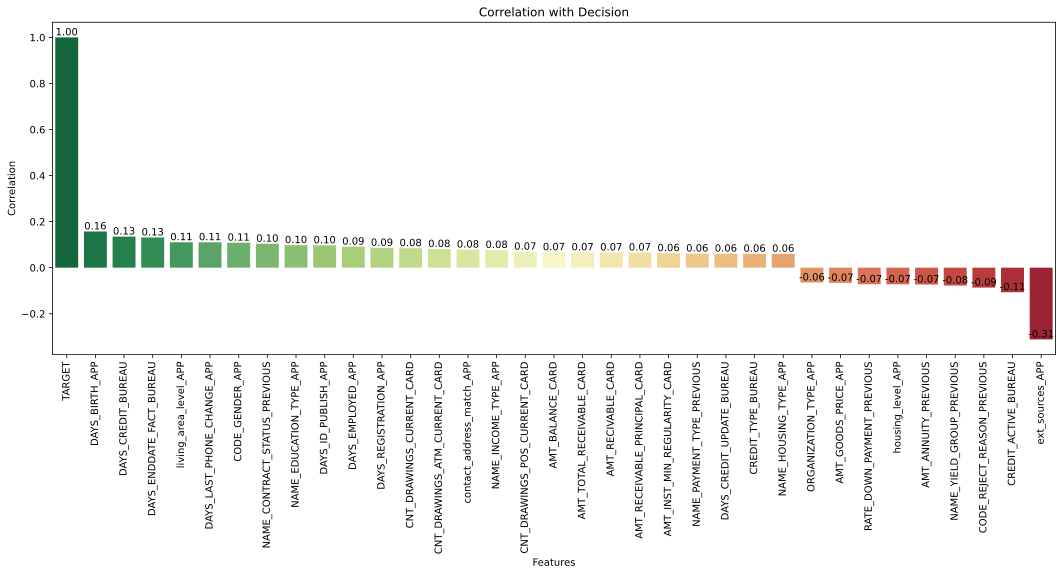

In [139]:
corr = balanced_encoded_data.corr()['TARGET'].sort_values(ascending=False)
significant_corr = corr[abs(corr) >= 0.06]
significant_columns = significant_corr.index.tolist()
plt.figure(figsize=(18, 6))
barplot = sns.barplot(x=significant_corr.index, y=significant_corr.values, palette="RdYlGn_r")
plt.xticks(rotation=90)
plt.title('Correlation with Decision')
plt.xlabel('Features')
plt.ylabel('Correlation')
for index, value in enumerate(significant_corr.values):
    barplot.text(index, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()


In [ ]:
correlation = []
p_values = []
for column in balanced_encoded_data.columns:
    if column != 'TARGET':
        corr, p_value = stats.pearsonr(balanced_encoded_data[column], balanced_encoded_data['TARGET'])
        correlation.append(corr)
        p_values.append(p_value)

correlation_df = pd.DataFrame({'Feature': balanced_encoded_data.columns.drop('TARGET'), 'Correlation': correlation, 'P-Value': p_values})

significant_corr = correlation_df[correlation_df['P-Value'] < 0.05]

significant_corr = significant_corr.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(18, 6))
barplot = sns.barplot(x=significant_corr['Feature'], y=significant_corr['Correlation'], palette="RdYlGn_r")
plt.xticks(rotation=90)
plt.title('Correlation with Decision')
plt.xlabel('Features')
plt.ylabel('Correlation')
for index, row in significant_corr.iterrows():
    barplot.text(index, row['Correlation'], f'{row["Correlation"]:.2f}', ha='center', va='bottom')
plt.show()

In [50]:
# creating two lists of "significant columns"- numeric and non-numeric
temp_data = eda_data[significant_columns].copy()
num_cols = temp_data.select_dtypes(include=['number']).columns.tolist()
num_cols.remove('TARGET')
cat_cols = temp_data.select_dtypes(exclude=['number']).columns.tolist()
print(f'There are {len(num_cols)} numeric columns and {len(cat_cols)} non numeric columns in the "significant column" group')

There are 27 numeric columns and 13 non numeric columns in the "significant column" group


In [51]:
#tranforming days into months for a more informative analysis
days_cols = [col for col in num_cols if col.startswith("DAYS_")]
days_cols.remove("DAYS_CREDIT_UPDATE_BUREAU")
temp_data[days_cols]=-temp_data[days_cols]/30
for col in days_cols:
    new_col_name = col.replace("DAYS_", "MONTHS_")
    temp_data.rename(columns={col: new_col_name}, inplace=True)

In [52]:
#cheking if conversion went well
month_cols = [col for col in temp_data.columns if col.startswith("MONTHS_")]
temp_data['MONTHS_EMPLOYED_APP'].head()

0     21.233333
1     39.600000
2      7.500000
3    101.300000
4    101.266667
Name: MONTHS_EMPLOYED_APP, dtype: float64

Since I used a lot of 0 to fill in the NaNs, my outlier analysis will suffer. Thus i eleminate the rows with 0, having a threshold for more than 50% of 0 in the column

In [53]:
#some colums had naturally many 0 so I leave them
threshold = 0.5
columns_with_0 = temp_data.columns[(temp_data == 0).mean() > threshold].tolist()
columns_with_0.remove('TARGET')
columns_with_0.remove('contact_address_match_APP')
columns_with_0.remove('DEF_30_CNT_SOCIAL_CIRCLE_APP')
columns_with_0

['CNT_DRAWINGS_CURRENT_CARD',
 'CNT_DRAWINGS_ATM_CURRENT_CARD',
 'CNT_DRAWINGS_POS_CURRENT_CARD',
 'AMT_BALANCE_CARD',
 'AMT_TOTAL_RECEIVABLE_CARD',
 'AMT_RECIVABLE_CARD',
 'AMT_RECEIVABLE_PRINCIPAL_CARD',
 'AMT_INST_MIN_REGULARITY_CARD',
 'AMT_DRAWINGS_ATM_CURRENT_CARD',
 'AMT_DRAWINGS_CURRENT_CARD']

In [54]:
temp_data_filtered = temp_data[(temp_data[columns_with_0]!=0).all(axis=1)]

In [55]:
selected_num_cals = month_cols + columns_with_0

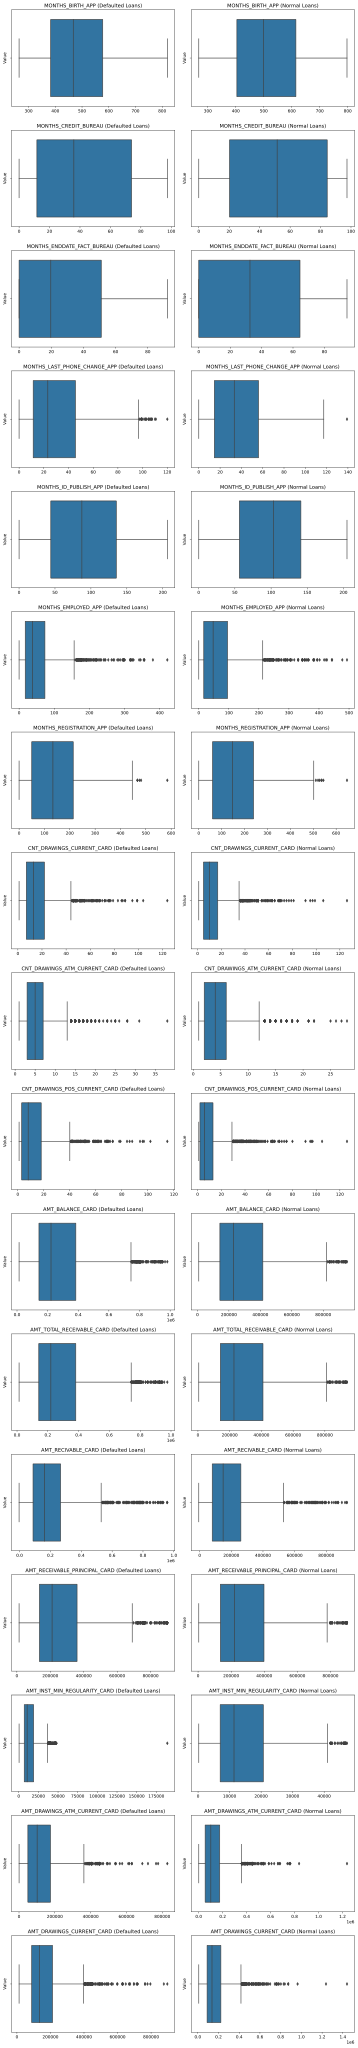

In [56]:
# calling initial boxploting function to see the rezult
boxplotting(temp_data_filtered, selected_num_cals, 2000)

Selected columns revealed that applicant age and credit history length differ for defaulted and normal clients. Other features have less differences.

Now, I will review other then selected numeric features.

In [57]:
#filtering out the selected columns
num_cols_alt = temp_data.select_dtypes(include=['number']).columns.tolist()
num_cols_alt.remove('TARGET')
filtered_num_cols = [col for col in num_cols_alt if col not in selected_num_cals]

In [58]:
#boxplotting selected columns
boxplotting(temp_data, filtered_num_cols, 10000)

This group has many outliers, thus I remove them for futher analysis.

In [59]:
#applying outlier removal function
temp_data_clean = remove_outliers(temp_data,filtered_num_cols)

In [60]:
#checking if filteres values have missing values
missing_values(temp_data_clean[filtered_num_cols])

The dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

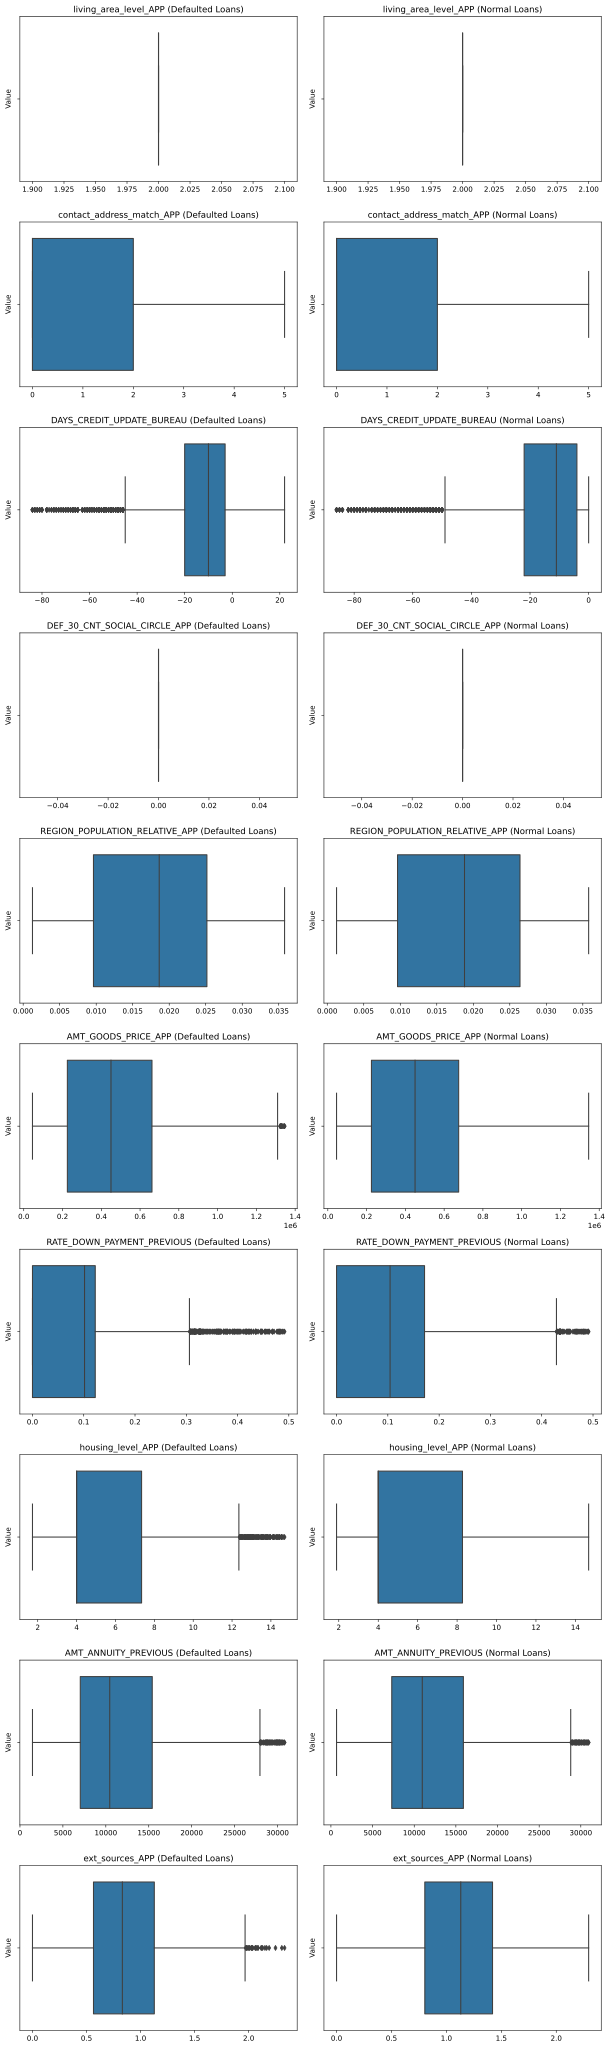

In [61]:
boxplotting(temp_data_clean, filtered_num_cols, 5000)

#### IV.5 Visual analysis
##### IV.5.1. Selected numeric values
After looking at the numeric columns boxplot, I have identified the following columns for further investigation and formation of the MAJOR list for default prediction: "AMT_INST_MIN_REGULARITY", "MONTHS_BIRTH", "MONTHS_CREDIT", "MONTHS_EMPLOYED", "MONTHS_ENDDATE_FACT", "MONTHS_ID_PUBLISH", "MONTHS_LAST_PHONE_CHANGE", "contact_address_match_APP", "ext_sources_APP". Now i want to look the distribution of these features visually.

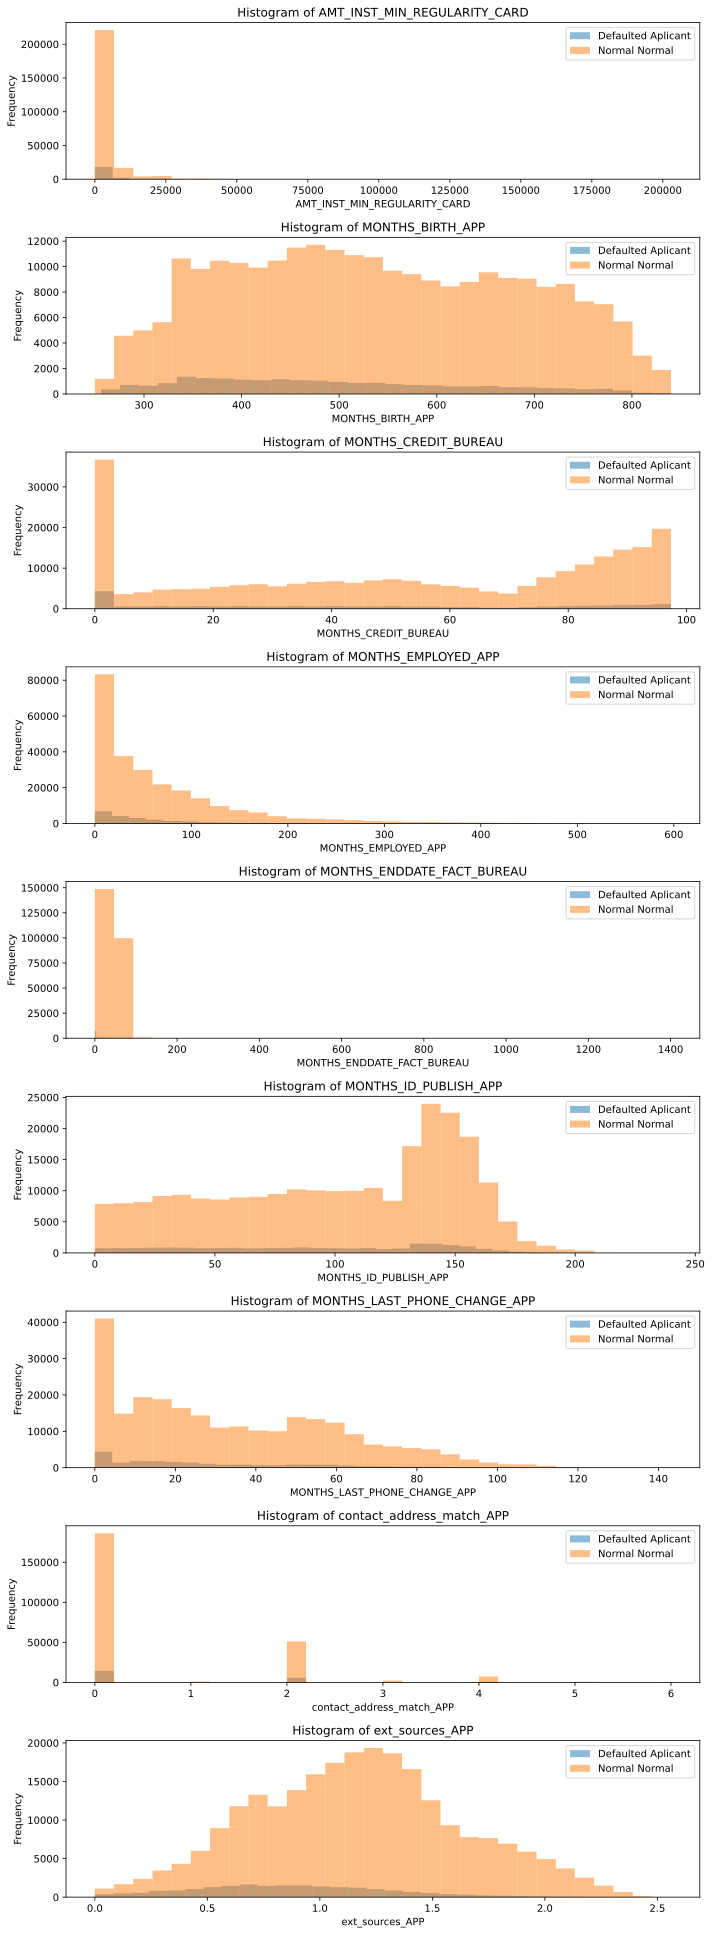

In [62]:
major_num_cols = ["AMT_INST_MIN_REGULARITY_CARD", "MONTHS_BIRTH_APP", "MONTHS_CREDIT_BUREAU", "MONTHS_EMPLOYED_APP", "MONTHS_ENDDATE_FACT_BUREAU", "MONTHS_ID_PUBLISH_APP", 
                  "MONTHS_LAST_PHONE_CHANGE_APP","contact_address_match_APP", "ext_sources_APP"]
defaulted_group = temp_data[temp_data["TARGET"] == 1]
normal_group = temp_data[temp_data["TARGET"] == 0]
rows = len(major_num_cols)
cols = 1
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,3*rows))
bins = 30
for idx, col in enumerate(major_num_cols):
    ax=axes[idx]
    defaulted_group[col].plot(kind='hist', ax=ax, alpha=0.5, label='Defaulted Aplicant', bins = bins)
    normal_group[col].plot(kind='hist', ax=ax, alpha=0.5, label='Normal Normal', bins = bins)
    
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()


plt.tight_layout()
plt.show()

##### IV.5.2. Categorical features visualiazation

In [63]:
temp_data[cat_cols].head()

CODE_GENDER_APP  ... CREDIT_ACTIVE_BUREAU
0               M  ...               Closed
1               F  ...               Closed
2               M  ...               Closed
3               F  ...                     
4               M  ...               Closed

[5 rows x 13 columns]

I will group the correlated features against Target variable

In [64]:
grouped_gender = grouping(temp_data, 'CODE_GENDER_APP')
grouped_gender

TARGET CODE_GENDER_APP    Normal  Defaulted
0                    F  167079.0    12432.0
1                    M   81896.0     9331.0
2                  XNA       4.0        0.0

In [65]:
grouped_gender_percentage = percentaging(grouped_gender)
grouped_gender_percentage

TARGET CODE_GENDER_APP  Normal  Defaulted
0                    F    93.1        6.9
1                    M    89.8       10.2
2                  XNA   100.0        0.0

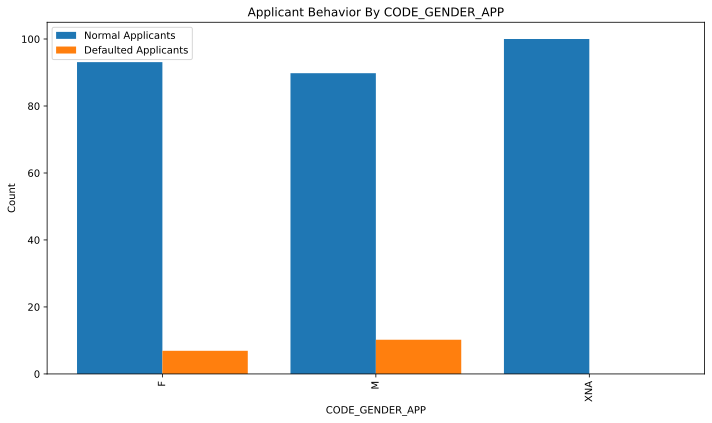

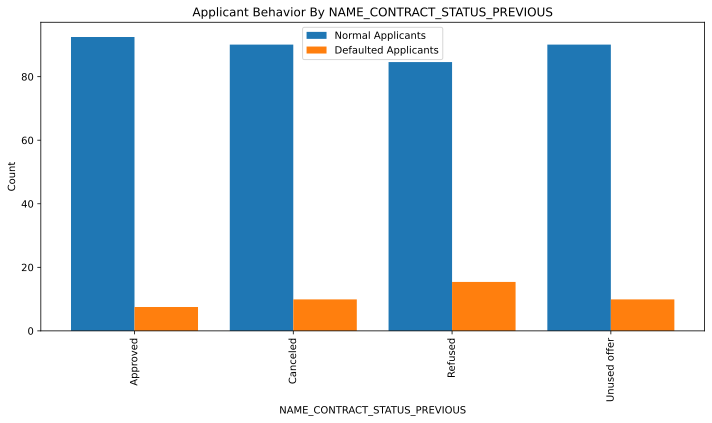

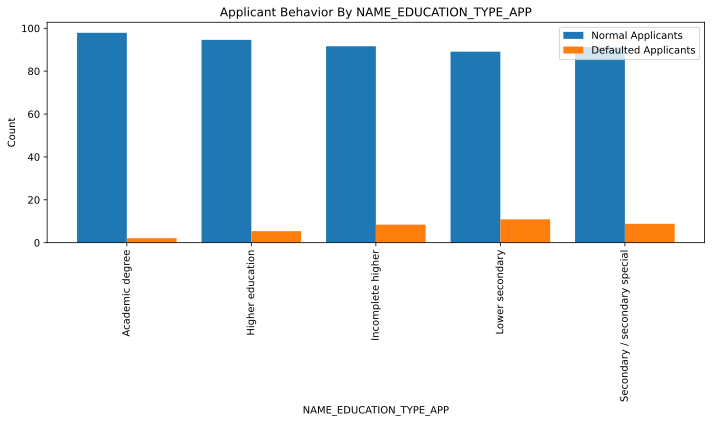

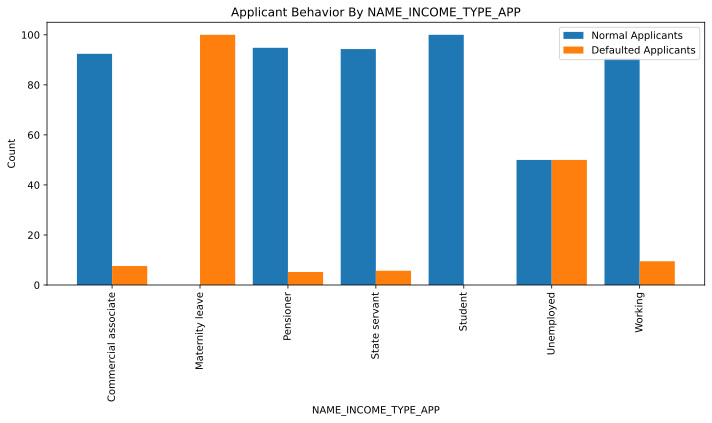

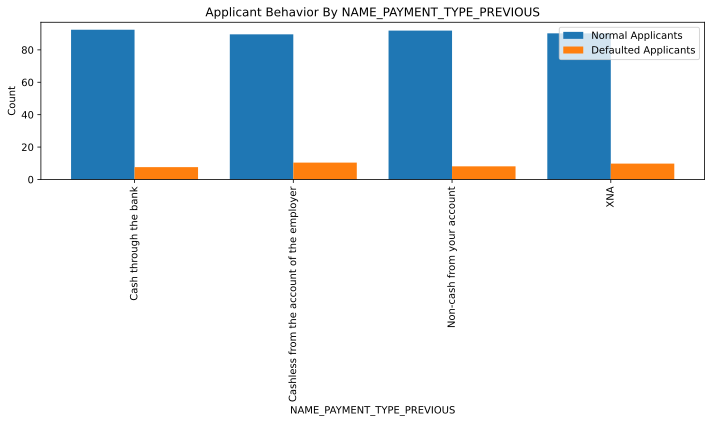

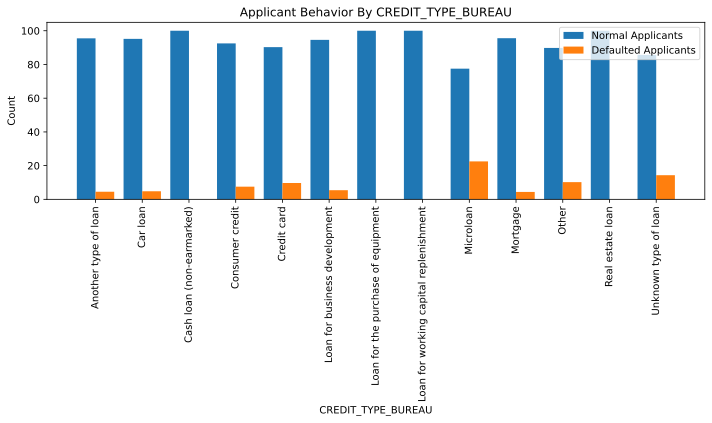

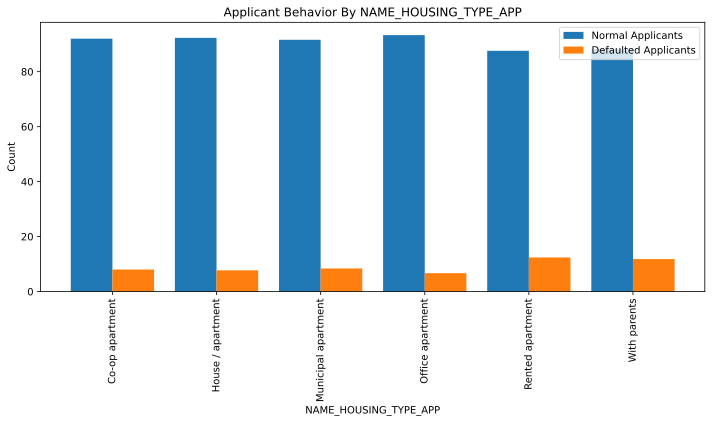

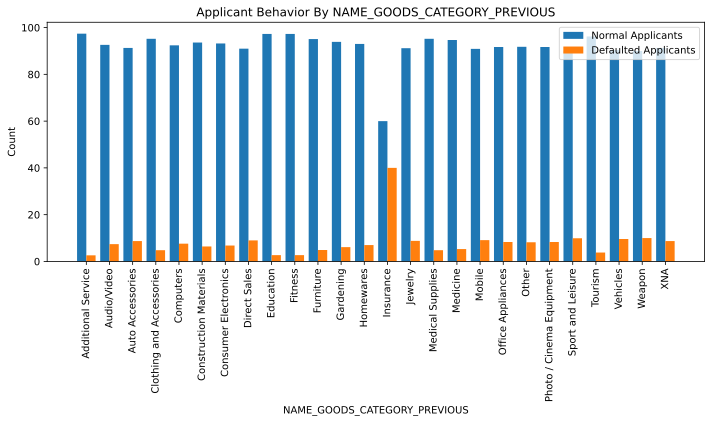

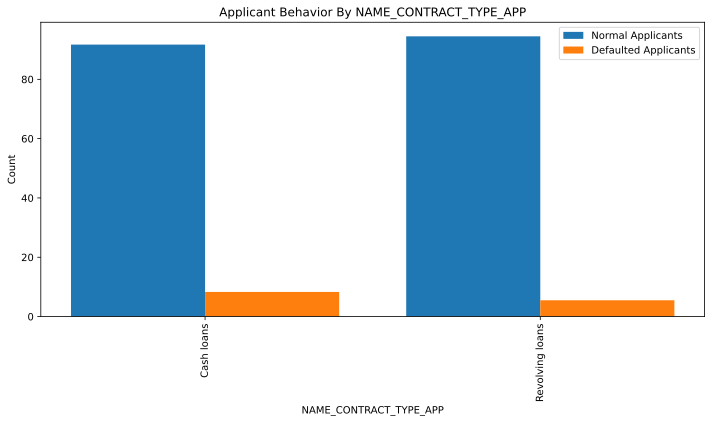

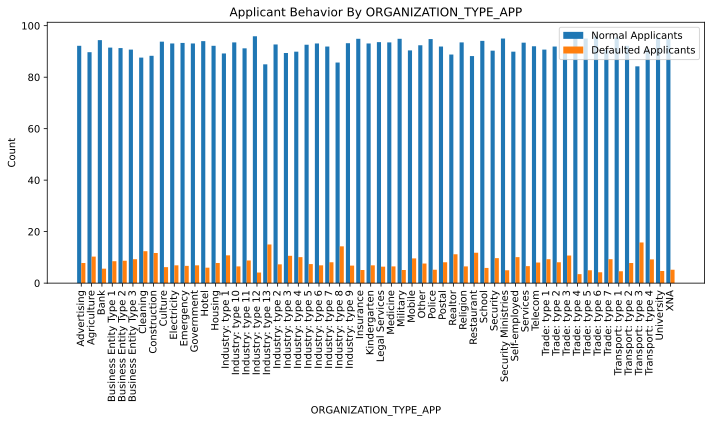

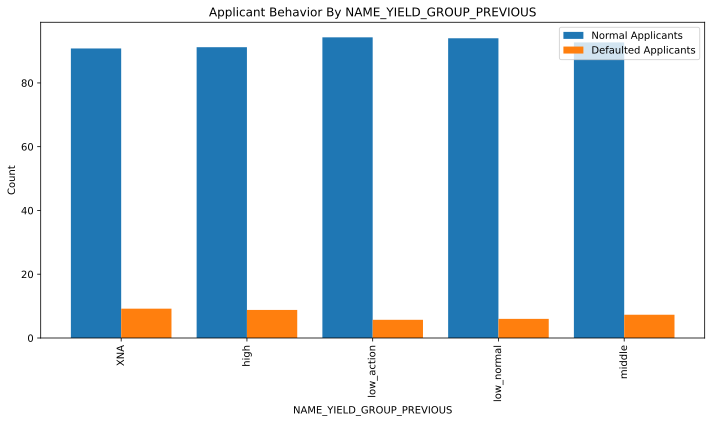

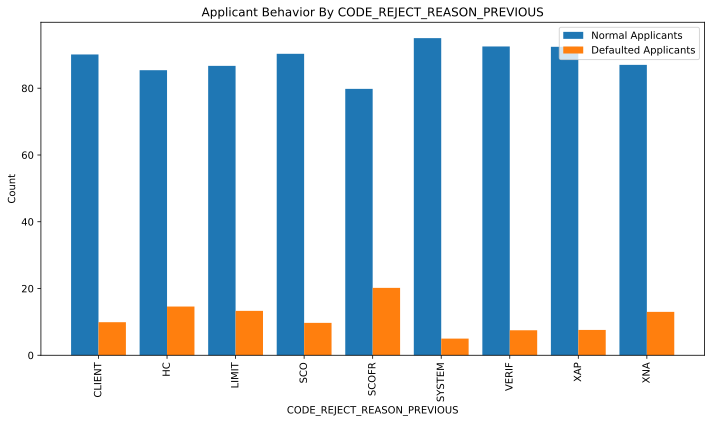

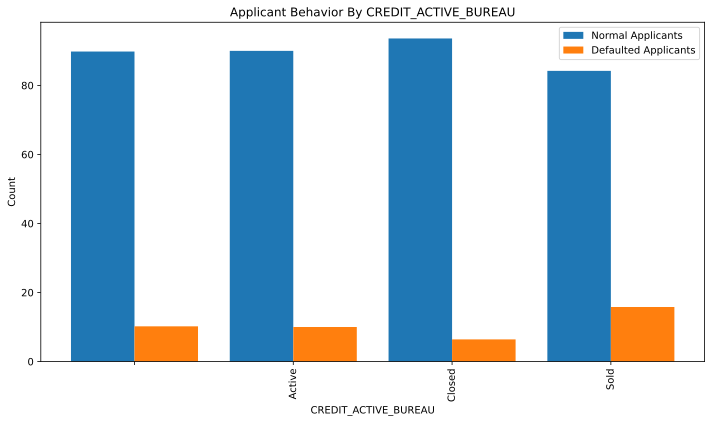

In [66]:
for cat_col in cat_cols:
    grouped_data = grouping(temp_data, cat_col)
    percentage_data = percentaging(grouped_data)
    plot_bar_chart(percentage_data, cat_col)

# V. Statistical Inference

Based on the visual analysis of categorical data behavior, I will test the following features for statistical significance because their variance seemed to be minimal: "NAME_PAYMENT_TYPE_PREVIOUS", "NAME_HOUSING_TYPE_APP", and "NAME_CONTRACT_TYPE_APP". 

Null Hypothesis (H0):

There is no significant association between the individually selected features such as "NAME_PAYMENT_TYPE_PREVIOUS," "NAME_HOUSING_TYPE_APP," or "NAME_CONTRACT_TYPE_APP" and the "TARGET" variable.

Alternative Hypothesis (Ha):

There is a significant association between the individually selected features such as "NAME_PAYMENT_TYPE_PREVIOUS," "NAME_HOUSING_TYPE_APP," or "NAME_CONTRACT_TYPE_APP" and the "TARGET" variable.

My confidence level is 0.05.

If there will be significant assosiation between these features and target variable, wI will keep them in the MAJOR list for ML training purposes, otherwise, I will drop them.

Since my population very large 270 thousand cases, I assume that the distributions are normal.

In [67]:
from scipy.stats import chi2_contingency

pd.set_option('display.width', 1000)

columns_to_test = ["NAME_PAYMENT_TYPE_PREVIOUS", "NAME_HOUSING_TYPE_APP", "NAME_CONTRACT_TYPE_APP"]

for col in columns_to_test:
    print(f"Analysis for column: {col}")
    contingency_table = pd.crosstab(temp_data[col], temp_data["TARGET"])

    # Chi-Squared Test
    chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
    print("Chi-Squared Test:")
    print(f"Chi-Squared Statistic: {chi2:.10f}")
    print(f"P-value: {p_chi2:.10f}")

    # G-test (Likelihood Ratio Test)
    g, p_g, _, _ = chi2_contingency(contingency_table, lambda_="log-likelihood")
    print("G-test (Likelihood Ratio Test):")
    print(f"G-statistic: {g:.10f}")
    print(f"P-value: {p_g:.10f}")
    print("---------------------------")

Analysis for column: NAME_PAYMENT_TYPE_PREVIOUS
Chi-Squared Test:
Chi-Squared Statistic: 276.1918861053
P-value: 0.0000000000
G-test (Likelihood Ratio Test):
G-statistic: 263.9498319893
P-value: 0.0000000000
---------------------------
Analysis for column: NAME_HOUSING_TYPE_APP
Chi-Squared Test:
Chi-Squared Statistic: 405.7904041780
P-value: 0.0000000000
G-test (Likelihood Ratio Test):
G-statistic: 361.6284897826
P-value: 0.0000000000
---------------------------
Analysis for column: NAME_CONTRACT_TYPE_APP
Chi-Squared Test:
Chi-Squared Statistic: 231.2247432029
P-value: 0.0000000000
G-test (Likelihood Ratio Test):
G-statistic: 255.1072435036
P-value: 0.0000000000
---------------------------


Statistical inference analysis rejected Null hypothesis. Thus, I choose to keep all the categorical colums from the Significant column list. My final MAJOR list for modeling is the following: 

Numeric Columns: "AMT_INST_MIN_REGULARITY_CARD", "DAYS_BIRTH_APP", "DAYS_CREDIT_BUREAU", "DAYS_EMPLOYED_APP", 
        "DAYS_ENDDATE_FACT_BUREAU", "DAYS_ID_PUBLISH_APP","DAYS_LAST_PHONE_CHANGE_APP",
        "contact_address_match_APP", "ext_sources_APP"

Categorical Columns:  "CODE_GENDER_APP", "NAME_CONTRACT_STATUS_PREVIOUS", "NAME_EDUCATION_TYPE_APP", "NAME_INCOME_TYPE_APP", 
        "NAME_PAYMENT_TYPE_PREVIOUS", "CREDIT_TYPE_BUREAU","NAME_HOUSING_TYPE_APP", "NAME_GOODS_CATEGORY_PREVIOUS", 
        "CREDIT_CURRENCY_BUREAU","NAME_CONTRACT_TYPE_APP","ORGANIZATION_TYPE_APP", "NAME_YIELD_GROUP_PREVIOUS",
        "CODE_REJECT_REASON_PREVIOUS"

For modeling will be working with the following models: Decision Tree, Random Forest, Light GBM, and XGBoost.

I will use original data set with all the outliers and missing values. 



In [68]:
nums = ["TARGET", "AMT_INST_MIN_REGULARITY_CARD", "DAYS_BIRTH_APP", "DAYS_CREDIT_BUREAU", "DAYS_EMPLOYED_APP", 
        "DAYS_ENDDATE_FACT_BUREAU", "DAYS_ID_PUBLISH_APP","DAYS_LAST_PHONE_CHANGE_APP",
        "contact_address_match_APP", "ext_sources_APP"]

cats = ["CODE_GENDER_APP", "NAME_CONTRACT_STATUS_PREVIOUS", "NAME_EDUCATION_TYPE_APP", "NAME_INCOME_TYPE_APP", 
        "NAME_PAYMENT_TYPE_PREVIOUS", "CREDIT_TYPE_BUREAU","NAME_HOUSING_TYPE_APP", "NAME_GOODS_CATEGORY_PREVIOUS", 
        "CREDIT_CURRENCY_BUREAU","NAME_CONTRACT_TYPE_APP","ORGANIZATION_TYPE_APP", "NAME_YIELD_GROUP_PREVIOUS",
        "CODE_REJECT_REASON_PREVIOUS"]

major_cols = nums + cats

In [69]:
# checking if all the major tables are in the joined data table
missing_columns = [col for col in major_cols if col not in joined_data.columns]

if len(missing_columns) == 0:
    print("All major_cols are present in the joined_data dataset.")
else:
    print("These major_cols are missing in the joined_data dataset:", missing_columns)


All major_cols are present in the joined_data dataset.


# VI. Modeling

For the modeling intially I will be working with four clasification models: decision tree, random forest, lightgbm, and xgboost.

I will test them on Major columns, full joined_data, and on app_train (unprocessed) tables. I will chose the model and table, which performs the best for further model training and deployment.

In [70]:
#cheking the balance of the dataset
defaulted_group = joined_data[joined_data["TARGET"] == 1]
normal_group = joined_data[joined_data["TARGET"] == 0]
print(f"Potential default group make {len(defaulted_group )} cases.")
print(f"Normal group make {len(normal_group )} cases.")
print(
    f"Default group make {len(defaulted_group)/len(joined_data)*100:.2f} % of the total dataset."
)

Potential default group make 24825 cases.
Normal group make 282686 cases.
Default group make 8.07 % of the total dataset.


In [112]:
#balansing the data
X = joined_data.drop(['TARGET'], axis=1)
y = joined_data['TARGET']

print("Original class distribution:", Counter(y))

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Undersampled class distribution:", Counter(y_resampled))

undersampled_joined_data = pd.concat([X_resampled, y_resampled], axis=1)

Original class distribution: Counter({0: 282686, 1: 24825})
Undersampled class distribution: Counter({0: 24825, 1: 24825})


In [113]:
# preparing two tables for modeling
modeling_data_major_cols = joined_data[major_cols].copy()
modeling_data = undersampled_joined_data.copy()

In [73]:
#evaluating the models on Major columns table
evaluate_models(modeling_data_major_cols)

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Decision Tree  0.858787   0.123180  0.128939  0.125994  0.525139
1  Random Forest  0.920736   0.307692  0.003296  0.006521  0.501330
2       LightGBM  0.670488   0.143445  0.638517  0.234263  0.655872
3        XGBoost  0.901858   0.257893  0.129557  0.172471  0.548803

In [114]:
#evaluating the models on full joined_data table
evaluate_models(modeling_data)

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Decision Tree  0.584189   0.583450  0.589207  0.586314  0.584188
1  Random Forest  0.684189   0.691423  0.665526  0.678227  0.684193
2       LightGBM  0.696173   0.696988  0.694321  0.695652  0.696174
3        XGBoost  0.692145   0.693180  0.689690  0.691430  0.692146

In [135]:
#undersampling the original unprocess app_train table
X = app_train.drop(['TARGET'], axis=1)
y = app_train['TARGET']

print("Original class distribution:", Counter(y))

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Undersampled class distribution:", Counter(y_resampled))

undersampled_original_data = pd.concat([X_resampled, y_resampled], axis=1)

Original class distribution: Counter({0: 282686, 1: 24825})
Undersampled class distribution: Counter({0: 24825, 1: 24825})


In [136]:
#evaluating app_train table
evaluate_models(undersampled_original_data)

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Decision Tree  0.574622   0.575315  0.570681  0.572988  0.574623
1  Random Forest  0.663142   0.667493  0.650423  0.658848  0.663145
2       LightGBM  0.668580   0.671513  0.660290  0.665854  0.668582
3        XGBoost  0.660725   0.662000  0.657068  0.659525  0.660726

Based on various scenarious, I will conginue working with the full set of joined features and will use lightgbm model for training my best estimator.

In [107]:
#eliminating the outlier that breaks the model
temp_mode_value = modeling_data['NAME_CASH_LOAN_PURPOSE_PREVIOUS'].mode().iloc[0]
modeling_data['NAME_CASH_LOAN_PURPOSE_PREVIOUS'].replace("Hobby", temp_mode_value, inplace=True)


For model performance testing I will use recall and roc auc values. 

Recall is the ratio of correctly predicted positive observations to the total actual positives. It measures the ability of the model to capture all the relevant cases.

It is important because in scenarios where the cost of false negatives (missing positive cases) is high, recall becomes crucial. In case of predicting loan behavior the cost of bad prediction can cause lots of financial losses, as well as bad reputation for financial institution, who rejects the applicant based on prediction.

ROC AUC is a good overall metric when the balance between sensitivity and specificity is important, and the cost of false positives and false negatives is not heavily skewed in one direction.

In [118]:
# testing the model individually
X = modeling_data.drop(['TARGET'], axis=1)
y = modeling_data['TARGET']

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        
        self.label_encoders = {}
        
        
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        for col in categorical_features:
            X[col] = X[col].fillna(X[col].mode().iloc[0])
            self.label_encoders[col] = LabelEncoder()
            X[col] = self.label_encoders[col].fit_transform(X[col])
        
        
        self.mean_values = X.select_dtypes(exclude=['object']).mean()
        
        return self

    def transform(self, X):
        
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        for col in categorical_features:
            X[col] = X[col].fillna(X[col].mode().iloc[0])
            X[col] = self.label_encoders[col].transform(X[col])
        
        
        numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()
        for col in numerical_features:
            X[col] = X[col].fillna(self.mean_values[col])
        
        return X


X = modeling_data.drop(['TARGET'], axis=1)
y = modeling_data['TARGET']


categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('labelencoder', OneHotEncoder(sparse=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = LGBMClassifier(random_state=0, class_weight='balanced')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy_s = accuracy_score(y_test, y_pred)
precision_s = precision_score(y_test, y_pred)
recall_s = recall_score(y_test, y_pred)
f1_s = f1_score(y_test, y_pred)
roc_auc_s = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy_s}')
print(f'Precision: {precision_s}')
print(f'Recall: {recall_s}')
print(f'F1 Score: {f1_s}')
print(f'ROC AUC: {roc_auc_s}')

c:\Users\DeivydasPagojus\AppData\Local\Programs\Python\Python311\Scripts\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 19859, number of negative: 19861
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13903
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 324
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Accuracy: 0.7010070493454179
Precision: 0.7019211324570273
Recall: 0.6989528795811518
F1 Score: 0.7004338613661588
ROC AUC: 0.7010074631588272


In [119]:
# Tuning hyperparameters and defining best estimator
X = modeling_data.drop(['TARGET'], axis=1)
y = modeling_data['TARGET']

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.label_encoders = {}
                
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        for col in categorical_features:
            X[col] = X[col].fillna(X[col].mode().iloc[0])
            self.label_encoders[col] = LabelEncoder()
            X[col] = self.label_encoders[col].fit_transform(X[col])
        
        self.mean_values = X.select_dtypes(exclude=['object']).mean()
        
        return self

    def transform(self, X):
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
        for col in categorical_features:
            X[col] = X[col].fillna(X[col].mode().iloc[0])
            X[col] = self.label_encoders[col].transform(X[col])
        
        numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()
        for col in numerical_features:
            X[col] = X[col].fillna(self.mean_values[col])
        
        return X

param_space = {
    'n_estimators': (200, 300, 500, 1000),
    'max_depth': (2, 5, 10, 20),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

lgbm = LGBMClassifier(random_state=0)

bayes_search = BayesSearchCV(
    lgbm, param_space, n_iter=5, cv=5, n_jobs=-1, scoring='recall', random_state=0
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


pipeline = Pipeline(steps=[
    ('preprocessor', CustomPreprocessor()),  
    ('model', bayes_search)
])

pipeline.fit(X_train, y_train)

y_pred_recall = pipeline.predict(X_test)

recall = recall_score(y_test, y_pred_recall)
print("Recall with best hyperparameters:", recall)

roc_auc = roc_auc_score(y_test, y_pred_recall)
print("ROC AUC with best hyperparameters:", roc_auc)

c:\Users\DeivydasPagojus\AppData\Local\Programs\Python\Python311\Scripts\Lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 19859, number of negative: 19861
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13744
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499975 -> initscore=-0.000101
[LightGBM] [Info] Start training from score -0.000101
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] 

After hyperparameter tunning I want to check which features play the most important role in decision making. I will use split and gain importance techniques.

Split Importance focuses on the frequency of feature usage in making decisions, indicating the importance of a feature in constructing the tree structure.

Gain Importance takes into account both the frequency and quality of feature usage, providing a more comprehensive measure of a feature's impact on the model's performance.

When interpreting these metrics, it's common to look at both to get a complete understanding of feature importance. A high split importance suggests a feature is important in shaping the tree structure, while high gain importance indicates that the feature contributes significantly to reducing the overall error of the model.

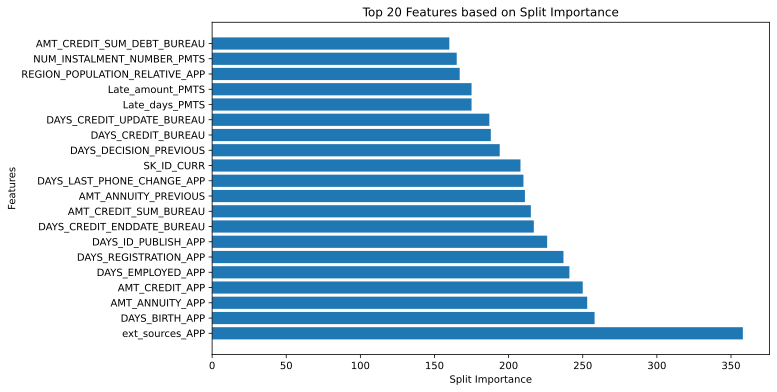

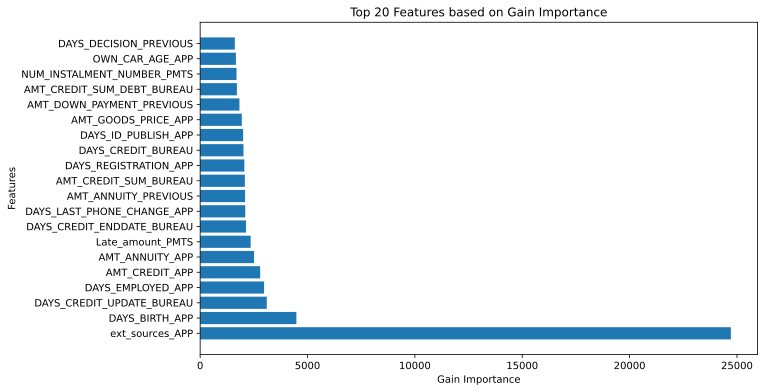

In [128]:
# indentifying the split and gain features
booster = pipeline.named_steps['model'].best_estimator_.booster_
split_importance = booster.feature_importance(importance_type='split')
gain_importance = booster.feature_importance(importance_type='gain')
top_split_features = X.columns[np.argsort(split_importance)[::-1][:20]]

top_split_indices = [X.columns.get_loc(feature) for feature in top_split_features]

plt.figure(figsize=(10, 6))
plt.barh(top_split_features, split_importance[top_split_indices])
plt.xlabel('Split Importance')
plt.ylabel('Features')
plt.title('Top 20 Features based on Split Importance')
plt.show()

top_gain_features = X.columns[np.argsort(gain_importance)[::-1][:20]]

top_gain_indices = [X.columns.get_loc(feature) for feature in top_gain_features]

plt.figure(figsize=(10, 6))
plt.barh(top_gain_features, gain_importance[top_gain_indices])
plt.xlabel('Gain Importance')
plt.ylabel('Features')
plt.title('Top 20 Features based on Gain Importance')
plt.show()

In [131]:
#create the list for one more model testing
top_split_features = set(X.columns[np.argsort(split_importance)[::-1][:20]])
top_gain_features = set(X.columns[np.argsort(gain_importance)[::-1][:20]])
combined_top_features = list(top_split_features.union(top_gain_features))
combined_top_features.append("TARGET")

In [132]:
evaluate_models(modeling_data[combined_top_features])

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Decision Tree  0.582679   0.582069  0.586992  0.584520  0.582678
1  Random Forest  0.673917   0.680527  0.655860  0.667966  0.673921
2       LightGBM  0.682075   0.682912  0.680024  0.681465  0.682075
3        XGBoost  0.677341   0.677764  0.676400  0.677081  0.677342

Based on this additional test, the results of fewer features used did not perform better than using all the possible features. Thus, I stay at my best estimator model.

In [140]:
best_estimator = bayes_search.best_estimator_

In [145]:
#testing the trained model on randomly chosen sample
modeling_data_clean = modeling_data.dropna()
sample1 = modeling_data_clean.sample(n=1)
sample_test_X = sample1.drop('TARGET', axis=1)
sample_test_y = sample1['TARGET']

sample_test_X = pipeline.named_steps['preprocessor'].transform(sample_test_X)

y_predict = pipeline.named_steps['model'].predict(sample_test_X)

print(y_predict)
print(sample_test_y)


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]
245104    0
Name: TARGET, dtype: int8


In [146]:
#saving the model to pikle file
with open('model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [147]:
#loading pickle file to test it
with open('model.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

In [148]:
#testing pickle file 
sample1 = modeling_data_clean.sample(n=1)

sample_test_X = sample1.drop('TARGET', axis=1)
sample_test_y = sample1['TARGET']

sample_test_X = loaded_pipeline.named_steps['preprocessor'].transform(sample_test_X)

y_predict = loaded_pipeline.named_steps['model'].predict(sample_test_X)

print(y_predict)
print(sample_test_y)

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[0]
170962    0
Name: TARGET, dtype: int8


In [133]:
# creating a sample df for github
joined_data_sample = joined_data.sample(n=1000)
joined_data_sample.to_csv('joined_data_sample.csv', index=False)
test_data_sample = test_data.sample(n=1000)
test_data_sample.to_csv('test_data_sample.csv', index=False)

# VII Conclusions

Throught the EDA I have identified the features that correlate with the target variable the most. I checked those features visually and statistically. I assumed that with the chosen features the model will work better than with the entire dataset. However, the model peroformed the best with the joined data.

The best model grants ~ 70% of recall. 

I assumed that I will provide a model for the lending companies with fewer features to predict the potential default of the credit applicant. However, the modeling part proved that the more features are provided the better accuracy of prediction. 

Thus, I have created a model, which can predict the behavior of the applicant based on all the standart features that a credit company is able to accumulate during the process of credit analysis. 

# VIII. Recommendations

After finishing the project, here are the recommendations for model improvement.

1. Testing different aggregations strategies for all the tables.
2. Testing modeling without aggregation - alhough it is time consuming, maybe it would generate better accuracy and recall
3. Investing more time in feature selection, feature engineering, and feature weight analysis. 